In this Jupyter Notebook we run the experiments of Section 6.2 for the MNIST dataset.

First of all, we have to import the required libraries as well as the data.

In [1]:
from keras.datasets import mnist
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt
from CF_NeuralNetwork import FFNN
from CF_NeuralNetwork_PC import FFNNPC

#Load the training set and normalize it
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train=X_train/X_train.sum(axis=(1,2))[:,None,None]
X_train=np.reshape(X_train,(np.size(X_train,0),28*28))
X_test=X_test/X_test.sum(axis=(1,2))[:,None,None]
X_test=np.reshape(X_test,(np.size(X_test,0),28*28))
Y_train=np.loadtxt('MNIST_D_train.gz', delimiter=',')
Y_test=np.loadtxt('MNIST_D_test.gz', delimiter=',')
X_tot=np.concatenate((X_test,X_train),axis=0)
Y_tot=np.concatenate((Y_train,Y_test),axis=0)

# Transform data to torch variables
x_Train_t=Variable(torch.from_numpy(X_train).float(), requires_grad=True)
y_Train_t=Variable(torch.from_numpy(Y_train).float(), requires_grad=False)
x_Test_t=Variable(torch.from_numpy(X_test).float(), requires_grad=False)
y_Test_t=Variable(torch.from_numpy(Y_test).float(), requires_grad=False)
x_Tot_t=Variable(torch.from_numpy(X_tot).float(), requires_grad=False)

# Our loss function is the mean relative error
def my_rel_loss(output,target):
    loss=torch.abs(output-target)
    loss=loss/target
    loss=torch.mean(loss)
    return loss

2023-11-15 12:13:18.121752: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-15 12:13:18.124788: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-15 12:13:18.207455: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-15 12:13:18.208377: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 12:13:19.584951: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Experiment 6.4: In this experiment, the part of the neural network representing the maxima function is fixed, whilst the first hidden layer is randomly initialized and trainable. We consider number_potentials=2^12 neurons in the first hidden layer and train the neural network over 300 epochs. 

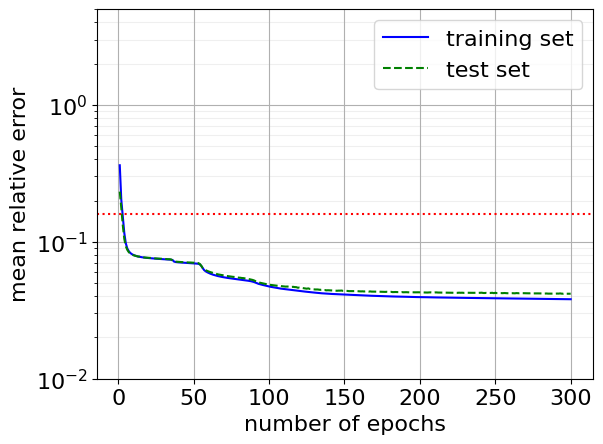

In [2]:
# Initialize the neural network
dimension_space=x_Train_t.size(dim=1)
number_potentials=2**12
model=FFNN(dimension_space,number_potentials,True)
optimizer = torch.optim.Adam(model.parameters())
epochs=300
batch_size = 64

# Training Loss
epoch_Loss=[]
# List for the epochs
epoch_list=[]
# Test Loss
epoch_Loss_Val=[]

for epochc in range(epochs):
    permutation = torch.randperm(x_Train_t.size()[0])
    acc_loss=0
    counter=0
    for i in range(0,x_Train_t.size()[0], batch_size):
        optimizer.zero_grad()
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_Train_t[indices], y_Train_t[indices]
        y_pred=model(batch_x)
        y_pred=y_pred.reshape(-1)
        loss=my_rel_loss(y_pred,batch_y)
        loss.backward()
        optimizer.step()
        acc_loss += loss
        counter += 1
    loss_app=acc_loss/counter
    y_pred_val=model(x_Test_t)
    y_pred_val=y_pred_val.reshape(-1)
    loss_Val=my_rel_loss(y_pred_val,y_Test_t)
    epoch_Loss_Val.append(loss_Val.detach().numpy())
    epoch_Loss.append(loss_app.detach().numpy())
    epoch_list.append(epochc+1)

# Create numpy arrays for the plots
counter=np.array(epoch_list)
mse_loss=np.array(epoch_Loss)
mse_loss_val=np.array(epoch_Loss_Val)

# Generate the plots
fig, ax = plt.subplots()
ax.set_ylim([0.01, 0.5])
plt.xlabel('number of epochs',fontsize=16)
plt.ylabel('mean relative error',fontsize=16)
plot_1a, =ax.semilogy(counter,mse_loss,color='blue',label='training set')
plot_1b, =ax.semilogy(counter,mse_loss_val,'--',color='green',label='test set')
plt.axhline(y = 0.159429, color = 'r', linestyle = ':')
ax.legend(handles=[plot_1a,plot_1b],loc='upper right',fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.grid()
plt.grid(which='minor',alpha=0.2)
plt.show()

Experiment 6.5: We repeat the experiment from before, however the first hidden layer will be initialized with 2^12 pre-computed Kantorovich potentials. 

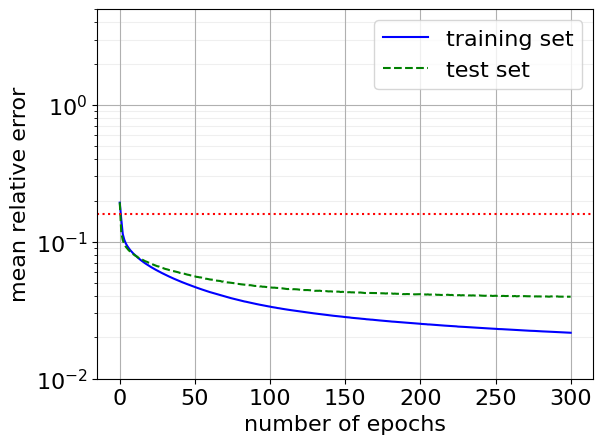

In [3]:
# Initialize the neural network with the pre-computed Kantorovich Potentials

bary0=np.loadtxt('BarycenterZero.gz', delimiter=',')
B0f=np.loadtxt('MNIST_P_f.gz', delimiter=',')
B0g=np.loadtxt('MNIST_P_g.gz', delimiter=',')
bary0=np.reshape(bary0,28*28)
bvectot=np.matmul(B0g,bary0)
idx=np.arange(B0f.shape[0])
np.random.shuffle(idx)
BS=B0f[idx,:]
bvecS=bvectot[idx]
dimension_space=x_Train_t.size(dim=1)
number_potentials=2**12
Amat=BS[:number_potentials,:]
bvec=bvecS[0:number_potentials]

model=FFNNPC(Amat,bvec,dimension_space,number_potentials,True)
optimizer = torch.optim.Adam(model.parameters())
epochs=300
batch_size = 64
# Training Loss
epoch_Loss=[]
# List for the epochs
epoch_list=[]
# Test Loss
epoch_Loss_Val=[]

# Initial erros; i.e., based on the pre-computed potentials, but without any training
y_pred_train=model(x_Train_t)
y_pred_train=y_pred_train.reshape(-1)
loss_train=my_rel_loss(y_pred_train,y_Train_t)
y_pred_test=model(x_Test_t)
y_pred_test=y_pred_test.reshape(-1)
loss_test=my_rel_loss(y_pred_test,y_Test_t)
epoch_Loss_Val.append(loss_test.detach().numpy())
epoch_Loss.append(loss_train.detach().numpy())
epoch_list.append(0)


for epochc in range(epochs):
    permutation = torch.randperm(x_Train_t.size()[0])
    acc_loss=0
    counter=0
    for i in range(0,x_Train_t.size()[0], batch_size):
        optimizer.zero_grad()
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_Train_t[indices], y_Train_t[indices]
        y_pred=model(batch_x)
        y_pred=y_pred.reshape(-1)
        loss=my_rel_loss(y_pred,batch_y)
        loss.backward()
        optimizer.step()
        acc_loss += loss
        counter += 1
    loss_app=acc_loss/counter
    y_pred_val=model(x_Test_t)
    y_pred_val=y_pred_val.reshape(-1)
    loss_Val=my_rel_loss(y_pred_val,y_Test_t)
    epoch_Loss_Val.append(loss_Val.detach().numpy())
    epoch_Loss.append(loss_app.detach().numpy())
    epoch_list.append(epochc+1)

# Create numpy arrays for the plots
counter=np.array(epoch_list)
mse_loss=np.array(epoch_Loss)
mse_loss_val=np.array(epoch_Loss_Val)


# Generate the plots
fig, ax = plt.subplots()
ax.set_ylim([0.01, 0.5])
plt.xlabel('number of epochs',fontsize=16)
plt.ylabel('mean relative error',fontsize=16)
plot_1a, =ax.semilogy(counter,mse_loss,color='blue',label='training set')
plot_1b, =ax.semilogy(counter,mse_loss_val,'--',color='green',label='test set')
plt.axhline(y = 0.159429, color = 'r', linestyle = ':')
ax.legend(handles=[plot_1a,plot_1b],loc='upper right',fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.grid()
plt.grid(which='minor',alpha=0.2)
plt.show()